In [1]:
#https://www.quantstart.com/articles/Backtesting-An-Intraday-Mean-Reversion-Pairs-Strategy-Between-SPY-And-IWM/
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from enum import Enum
import cointegration_mult as mult
import Cointegration as coint
import datetime
import math

importlib.reload(coint)
importlib.reload(mult)

<module 'cointegration_mult' from 'D:\\trades\\pairs_trading_b3\\cointegration_mult.py'>

In [2]:
class Historic(object):
    def __init__(self):
        self.type_input=TypeInput.Nada
        self.day_input=None
        self.price_y_input=None
        self.price_x_input=None
        self.day_output=None
        self.price_y_output=None
        self.price_x_output=None
        self.type_output=TypeOutput.Nada
        self.lot_y=100
        self.lot_x=100
        self.num_days=0
        
    def get(self):
        return [self.type_input.name, self.lot_y, self.lot_x, self.day_input, self.price_y_input, self.price_x_input,
                self.day_output, self.price_y_output, self.price_x_output, self.type_output.name,
                 self.balance_result(), self.percent()*100, self.num_days]

    def balance_result(self):
        return self.balance_long()+self.balance_short()
    
    def balance_long(self):
        if (self.type_input == TypeInput.LongShort):
            return (self.price_y_output*self.lot_y)-(self.price_y_input*self.lot_y)
        if (self.type_input == TypeInput.ShortLong):
            return (self.price_x_output*self.lot_x)-(self.price_x_input*self.lot_x)
        return 0
    
    def balance_short(self):
        if (self.type_input == TypeInput.LongShort):
            return (self.price_x_input*self.lot_x)-(self.price_x_output*self.lot_x)
        if (self.type_input == TypeInput.ShortLong):
            return (self.price_y_input*self.lot_y)-(self.price_y_output*self.lot_y)
        return 0
    
    def financial_long(self):
        if (self.type_input == TypeInput.LongShort):
            return (self.price_y_output*self.lot_y)
        if (self.type_input == TypeInput.ShortLong):
            return (self.price_x_input*self.lot_x)
        return 0
        
    def percent(self):
        return self.balance_result()/self.financial_long()
    
def diff_dates(date1, date2):
    date_one = datetime.datetime.strptime(date1, '%Y-%m-%d')
    date_two = datetime.datetime.strptime(date2, '%Y-%m-%d')
    return abs((date_one-date_two).days)

class TypeOutput(Enum):
    Nada = 0
    Aberto = 1
    Disintegrated = 2
    TakeProfit = 3
    StopLoss = 4
    
class TypeInput(Enum):
    Nada=0
    LongShort=1
    ShortLong=2
    
def roundup(value):
    #return int(math.ceil(value / 100.0)) * 100
    ret = int(round(value, -2))
    if (ret <= 0):
        return 100
    return ret

In [3]:
class BackTest(object):
    def __init__(self):
        self.day_start=None
        self.y_values=None
        self.x_values=None
        self.historic = Historic()
        self.list_historic=[]
        self.coef=None
        self.stop_executed=False
        self.cointegration=None
         
    def execute(self, desv_input=2, desc_input_max=2.5, desv_stop=3, desv_take=0.1, period=100, coef_fixed=False,
               min_adf=90, num_periods=3, min_halflife=0, invert_pair=False):
        
        # define properties
        self.min_adf = min_adf
        self.period = period
        self.num_periods = num_periods
        self.min_halflife = min_halflife
        
        days = data.index[::-1].tolist()
        for day in days:
            test = data[data.index <= day]
            if (len(test) < period):
                continue
                        
            if (self.day_start == None):
                self.day_start = day

            if (invert_pair) :
                self.y_values, self.x_values = mult.get_values(test[x_symbol], test[y_symbol], self.period)
            else:
                self.y_values, self.x_values = mult.get_values(test[y_symbol], test[x_symbol], self.period)
            
            # check se retornou a média após ter stopado
            if (self.check_return_mean_after_stoploss()==False):
                continue
                
            self.cointegration = mult.check_cointegration(self.y_values, self.x_values, self.period)
            if(self.cointegration['is_stationary']==False):
                self.disintegrated(day)
                continue

            # check se é pra trabalhar com coieficientes fixo
            if (self.check_trade() and coef_fixed):
                resid = mult.residue(self.y_values, self.x_values, self.period, self.coef)
            else:
                self.coef = mult.coefficients(self.y_values, self.x_values, self.period)
                resid = mult.residue(self.y_values, self.x_values, self.period, self.coef)
            
            z_resid = mult.zscore(resid)
            
            if (self.check_trade() == False):
                if (self.valid_entry()):
                    # procura por short/long
                    if (z_resid[0] >= desv_input and z_resid[0] <= desc_input_max):
                        self.short(day)
                    # procura por long/short
                    if (z_resid[0] <= -desv_input and z_resid[0] >= -desc_input_max):
                        self.long(day)

            if (self.check_trade()):
                self.historic.num_days+=1
                # check se short/long
                if (self.isShort()):
                    if (z_resid[0] >= desv_stop):# check stop loss
                        self.stop(day)
                    if (z_resid[0] <= desv_take):# check take profit
                        self.take(day)
                # check se long/short
                if (self.isLong()):
                    if (z_resid[0] <= -desv_stop):#  check stop loss
                        self.stop(day)
                    if (z_resid[0] >= desv_take):# check take profit
                        self.take(day)
        
        # os dados acabaram, então zera operação aberta se tiver
        self.zerar(day)

    def valid_entry(self):
        #if (self.valid_quant_periods()==False): return False
        if (self.valid_adf()==False): return False
        if (self.valid_haldlife()==False): return False
        return True
        
    def valid_haldlife(self):
        if (self.min_halflife <= 0):
            return True
        if(self.cointegration['halflife'] > self.min_halflife):
            return False
        return True
    
    def valid_adf(self):
        # check best adf
        if (self.cointegration['adf'] >= self.min_adf):
            return True
        return False
    
    def valid_quant_periods(self):
        # check num periods
        if (self.num_periods <= 0):
            return True
        periods = mult.check_periods(self.y_values, self.x_values)
        if(self.num_periods_cointegrated > len(periods)):
            return False
        return True
    
    def check_return_mean_after_stoploss(self):
        if (self.stop_executed==False):
            return True
        
        resid = mult.residue(self.y_values, self.x_values, self.period)
        z_resid = mult.zscore(resid)
        if (abs(z_resid[0]) <= 0.2):
            self.stop_executed=False
            return True
        return False
            
    def take(self, day):
        self.define_historic_output(day, TypeOutput.TakeProfit)
        self.startNew()
        
    def stop(self, day):
        self.define_historic_output(day, TypeOutput.StopLoss)
        self.stop_executed=True
        self.startNew()
        
    def long(self, day):
        lot_y_long = 100
        lot_x_short = self.lot_short_cash_neutral(self.y_values[0], self.x_values[0], lot_y_long)
        self.define_historic_input(day, lot_y_long, lot_x_short, TypeInput.LongShort)
    
    def short(self, day):
        lot_x_long = 100
        lot_y_short = self.lot_short_cash_neutral(self.x_values[0], self.y_values[0], lot_x_long)
        self.define_historic_input(day, lot_y_short, lot_x_long, TypeInput.ShortLong)

    def disintegrated(self, day):
        if (self.check_trade() == False):
            return False
        self.define_historic_output(day, TypeOutput.Disintegrated)
        self.startNew()
        return True
    
    def zerar(self, day):
        if (self.check_trade() == False):
            return False
        self.define_historic_output(day, TypeOutput.Aberto)
        self.startNew()
        return True

    def define_historic_input(self, day, lot_y, lot_x, typeInput):
        self.historic.day_input=day
        self.historic.price_y_input=self.y_values[0]
        self.historic.price_x_input=self.x_values[0]
        self.historic.lot_y = lot_y
        self.historic.lot_x = lot_x
        self.historic.type_input=typeInput

    def define_historic_output(self, day, type_outPut):
        self.historic.day_output=day
        self.historic.price_y_output=self.y_values[0]
        self.historic.price_x_output=self.x_values[0]
        self.historic.type_output=type_outPut

    def startNew(self):
        self.list_historic.append(self.historic)
        self.historic = Historic()

    def isShort(self):
        return self.historic.type_input == TypeInput.ShortLong

    def isLong(self):
        return self.historic.type_input == TypeInput.LongShort
    
    def check_trade(self):
        return self.isShort() or self.isLong()
    
    def dataframe(self):
        rows = []
        for his in self.list_historic:
            rows.append(his.get())
        hist = pd.DataFrame(rows, columns=['Oper', 'Lot. Dep', 'Lot. Ind', 'Ent. Data', 'Ent. Pç Dep', 'Ent. Pç Ind', 'Sai. Data', 'Sai. Pç Dep',
                                           'Sai. Pç Ind', 'Sai. tipo', 'Resultado', "Retorno %", 'Dias'])
        return hist
    
    def lot_short_cash_neutral(self, price_long, price_short, lot_long):
        return roundup((price_long*lot_long)/price_short)

    def lot_beta_cash_neutral(self, lot, beta):
        return lot * beta

    def results(self):
        results={}
        dfHist = self.dataframe()
        results['NumTrades']= len(dfHist)
        results['TakeProfit']= dfHist['Resultado'][dfHist['Sai. tipo'] == 'TakeProfit'].sum()
        results['StopLoss']= dfHist['Resultado'][dfHist['Sai. tipo'] == 'StopLoss'].sum()
        results['OperOpen']= dfHist['Resultado'][dfHist['Sai. tipo'] == 'Aberto'].sum()
        results['TakeProfitDisint']= dfHist['Resultado'][(dfHist['Sai. tipo'] == 'Disintegrated')\
                                                         & (dfHist['Resultado'] > 0)].sum()
        results['StopLossDisint']= dfHist['Resultado'][(dfHist['Sai. tipo'] == 'Disintegrated')\
                                                       & (dfHist['Resultado'] < 0)].sum()
        results['Result']= results['TakeProfit']+results['StopLoss']+results['OperOpen']\
            +results['TakeProfitDisint']+results['StopLossDisint']
        return results

In [4]:
path_data_cart = 'datasets/data_cart.csv'
path_data_yahoo = 'datasets/data_yahoo.csv'
path_data = 'datasets/data.csv'
path_data_meta = 'datasets/dataset_meta.csv'

In [5]:
data = pd.read_csv(path_data_meta, index_col=0)
#data = data[::-1]
pairs = pd.read_csv('datasets/cointegrated_pairs_mult.csv')

print('{} to {}'.format(data.index[-1], data.index[0]))
print('data: {}'.format(data.shape))
print('pairs: {}'.format(pairs.shape))

2020.07.01 12:00 to 2020.08.28 16:00
data: (300, 74)
pairs: (2243, 12)


In [6]:
data

,ABEV3,AZUL4,B3SA3,BBAS3,BBDC4,BBSE3,BEEF3,BPAC11,BRAP4,BRDT3,...,TAEE11,TIMP3,TOTS3,UGPA3,USIM5,VALE3,VIVT4,VVAR3,WEGE3,YDUQ3
DateTime,,,,,,,,,,,,,,,,,,,,,
2020.08.28 16:00,12.75,22.88,61.02,33.39,21.47,27.55,13.21,82.80,44.71,21.97,...,28.40,14.73,28.80,20.28,10.05,61.10,49.55,20.22,67.19,27.60
2020.08.28 15:00,12.70,22.78,60.87,33.40,21.46,27.79,13.32,82.49,44.57,21.83,...,28.34,14.70,28.69,20.17,10.04,61.09,49.40,20.28,67.52,27.69
2020.08.28 14:00,12.68,22.76,60.84,33.38,21.39,27.64,13.36,82.51,44.93,21.81,...,28.35,14.64,28.72,20.20,10.00,61.35,49.56,20.37,67.86,28.08
2020.08.28 13:00,12.69,22.73,61.03,33.34,21.31,27.68,13.32,82.70,44.87,21.77,...,28.34,14.64,28.70,20.21,10.00,61.51,49.66,20.50,67.89,27.96
2020.08.28 12:00,12.74,22.80,61.29,33.45,21.34,27.58,13.27,82.76,44.94,21.95,...,28.41,14.71,28.75,20.39,9.98,61.44,49.57,20.57,67.65,28.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020.07.01 16:00,14.36,20.67,56.03,32.69,21.13,26.86,12.84,76.07,35.44,21.32,...,27.72,14.47,23.70,18.80,7.34,54.33,48.08,15.99,52.49,34.41
2020.07.01 15:00,14.39,20.77,55.91,32.61,21.06,26.78,12.92,76.97,35.23,21.39,...,27.79,14.42,23.73,18.81,7.31,54.27,48.18,15.90,52.00,34.37
2020.07.01 14:00,14.47,20.68,56.59,32.69,21.12,26.79,12.92,77.39,35.18,21.36,...,27.83,14.46,23.62,18.90,7.26,54.36,48.20,15.82,52.05,34.36


In [7]:
# pares para analisar e melhorar o backtest
"""y_symbol = 'CIEL3'
x_symbol = 'ITUB4'"""

"y_symbol = 'CIEL3'\nx_symbol = 'ITUB4'"

In [8]:
# A Fazer
# 1. verificar se tá cointegrado em mais períodos
# 2. buscar oper somente dentro de um X dias de half-life
# 3. Stopar com X %
# 4. Take com X %

In [9]:
y_symbol = 'B3SA3'
x_symbol = 'ELET3'

y_symbol = 'ABEV3'
x_symbol = 'IRBR3'

period = 100
print('{}: {} / {}: {}'.format(y_symbol, data[y_symbol][0], x_symbol, data[x_symbol][0]))
#mult.plot_residue(mult.residue(data[y_symbol], data[x_symbol], period))

ABEV3: 12.75 / IRBR3: 7.5


In [18]:
coef_fixed = False
invert_pair = False

back = BackTest()
back.execute(period=period,
             desv_input=2,
             desc_input_max=2.5,
             desv_stop=3,
             coef_fixed=coef_fixed,
             invert_pair=invert_pair)
hist = back.dataframe()
hist

,Oper,Lot. Dep,Lot. Ind,Ent. Data,Ent. Pç Dep,Ent. Pç Ind,Sai. Data,Sai. Pç Dep,Sai. Pç Ind,Sai. tipo,Resultado,Retorno %,Dias
0,ShortLong,100,100,2020.07.27 10:00,15.11,8.05,2020.07.29 12:00,15.18,8.06,Disintegrated,-6.0,-0.745342,16
1,ShortLong,100,100,2020.08.14 11:00,13.35,7.55,2020.08.18 13:00,13.08,7.50,Disintegrated,22.0,2.913907,16
2,LongShort,100,200,2020.08.21 12:00,12.76,7.77,2020.08.26 10:00,12.93,8.04,TakeProfit,-37.0,-2.861562,21
3,ShortLong,100,100,2020.08.28 16:00,12.75,7.50,2020.08.28 16:00,12.75,7.50,Aberto,0.0,0.000000,1


In [11]:
back.results()

{'NumTrades': 4,
 'TakeProfit': -36.99999999999977,
 'StopLoss': 0.0,
 'OperOpen': 0.0,
 'TakeProfitDisint': 22.0,
 'StopLossDisint': -6.000000000000114,
 'Result': -20.999999999999886}

In [12]:
for per in mult.list_periods():
    back = BackTest()
    back.execute(period=per, invert_pair=invert_pair)
    print('---------------------------')
    result = back.results()
    print('Período: {}'.format(per))
    print('Nº trades: {}'.format(result['NumTrades']))
    print('Result: {}'.format(result['Result']))

---------------------------
Período: 100
Nº trades: 4
Result: -20.999999999999886
---------------------------
Período: 120
Nº trades: 1
Result: 9.0
---------------------------
Período: 140
Nº trades: 2
Result: 64.0
---------------------------
Período: 160
Nº trades: 1
Result: 4.0
---------------------------
Período: 180
Nº trades: 0
Result: 0
---------------------------
Período: 200
Nº trades: 0
Result: 0
---------------------------
Período: 220
Nº trades: 0
Result: 0
---------------------------
Período: 240
Nº trades: 0
Result: 0
---------------------------
Período: 250
Nº trades: 0
Result: 0


# Visualiza no Gráfico

Days: 20
PONTO DE ENTRADA


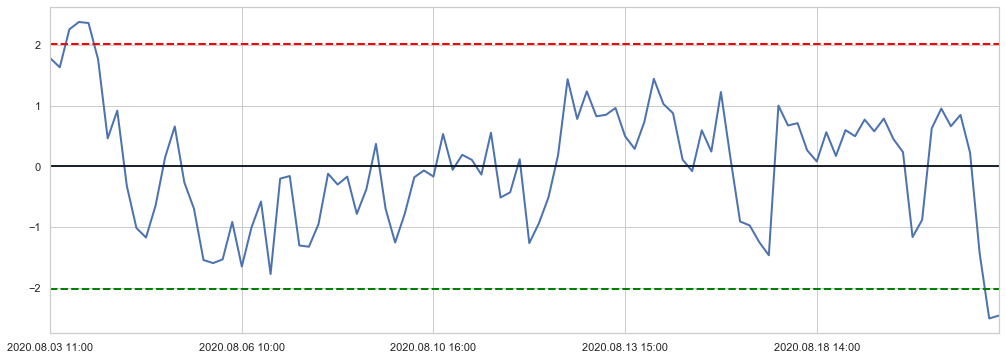

PONTO DE SAÍDA


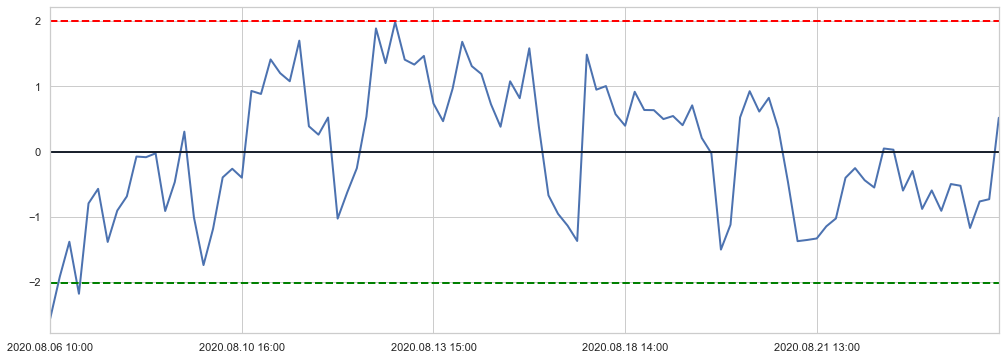

In [13]:
index=2
oper = hist.iloc[index]
day_start = oper['Ent. Data']
day_end = oper['Sai. Data']

test = data[data.index <= day_start]
test_stop = data[data.index <= day_end]
test_simu = data[(data.index >= day_start) & (data.index <= day_end)]

print('Days: {}'.format(abs(len(test)-len(test_stop))))

coef = mult.coefficients(test[y_symbol], test[x_symbol], period)
if(coef_fixed==False):
    coef=None

print("PONTO DE ENTRADA")
mult.plot_residue(mult.residue(test[y_symbol], test[x_symbol], period, coef))
print("PONTO DE SAÍDA")
mult.plot_residue(mult.residue(test_stop[y_symbol], test_stop[x_symbol], period, coef))

In [14]:
#test_simu[::-1][[y_symbol, x_symbol]].to_excel('datasets/backtest/backtest.xlsx')
#test_simu[[y_symbol, x_symbol]].to_excel('datasets/backtest/backtest.xlsx')

True
True


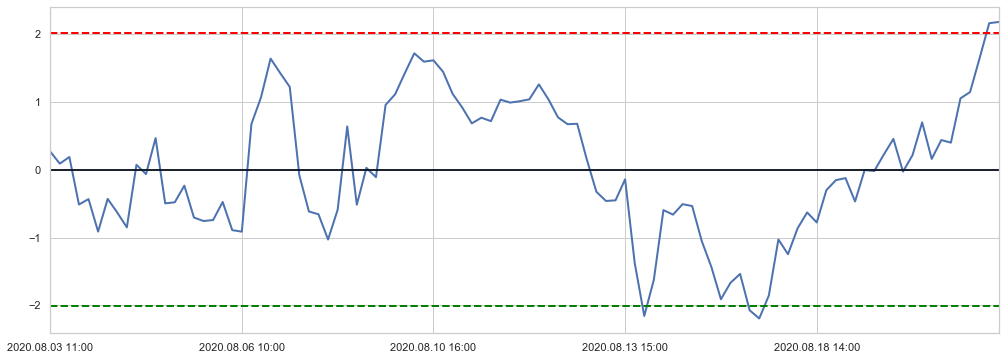

In [15]:
print(mult.invert(test['ENGI11'],test['GNDI3'], period))
print(mult.accept_temp(test['ENGI11'],test['GNDI3'], period))
mult.plot_residue(mult.residue(test['ENGI11'], test['GNDI3'], period))

False
False


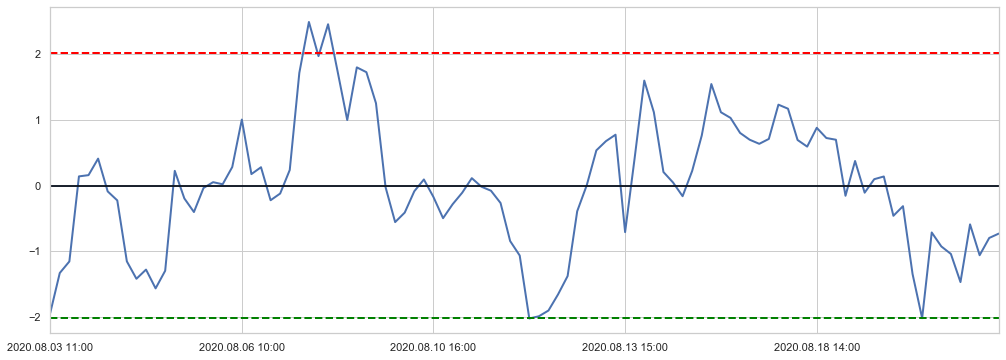

In [16]:
print(mult.invert(test['GNDI3'],test['ENGI11'], period))
print(mult.accept_temp(test['GNDI3'],test['ENGI11'], period))
mult.plot_residue(mult.residue(test['GNDI3'],test['ENGI11'], period))